In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
def compute_performance_metrics(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} Recall: {recall}")
    print(f"{model_name} F1 Score: {f1_score_value}")

def compute_classification_metric(dataset,predictions, label_name_v, favorable_label_v, unfavorable_label_v, privileged_attribute, unprivileged_attribute):
    features = [privileged_attribute] + unprivileged_attribute # We want to check the fairness level regarding the protected attribute "sex"

    # This is the object made of the original dataset
    aif_sex_dataset = BinaryLabelDataset( # Base class for all structured datasets with binary labels.
            df=dataset,
            favorable_label=favorable_label_v, # This means that a prediction is biased toward the privileged attribute if its value is 1 (True)
            unfavorable_label=unfavorable_label_v,
            label_names=[label_name_v],
            protected_attribute_names=features,
            privileged_protected_attributes=[privileged_attribute], # here we tell AIF that we want to check for predictions
        )

    # We do the same thing but with the predictions dataset
    aif_sex_pred = BinaryLabelDataset(
            df=predictions,
            favorable_label=favorable_label_v,
            unfavorable_label=unfavorable_label_v,
            label_names=[label_name_v],
            protected_attribute_names=features,
            privileged_protected_attributes=[privileged_attribute],
        )

    sex_privileged_group = [{privileged_attribute: 1, **{attr: 0 for attr in unprivileged_attribute}}]
    sex_unprivileged_group = [{attr: 1, privileged_attribute: 0} for attr in unprivileged_attribute]

    # We provide the ClassificationMetric object with all the information needed:
    # aif_sex_dataset - The original test set
    # aif_sex_pred - A dataset containing the predictions of the model
    # sex_privileged_group - The privileged group
    # sex_unprivileged_group - The unprivileged group
    fairness_metrics = ClassificationMetric(dataset=aif_sex_dataset,
                            classified_dataset=aif_sex_pred,
                            unprivileged_groups=sex_unprivileged_group,
                            privileged_groups=sex_privileged_group)
    
    return fairness_metrics

def compute_fairness_metrics(fairness_metrics: ClassificationMetric):
    # Values less than 0 indicate that privileged group has higher
    # proportion of predicted positive outcomes than unprivileged group.
    # Value higher than 0 indicates that unprivileged group has higher proportion
    # of predicted positive outcomes than privileged group.
    SPD = round(fairness_metrics.statistical_parity_difference(),3)

    # Measures the deviation from the equality of opportunity, which means that the same
    # proportion of each population receives the favorable outcome. This measure must be equal to 0 to be fair.
    EOD = round(fairness_metrics.equal_opportunity_difference(),3)

    # Average of difference in False Positive Rate and True Positive Rate for unprivileged and privileged groups
    # A value of 0 indicates equality of odds, which means that samples in both the privileged and unprivileged
    # groups have the same probability of being classified positively.
    AOD = round(fairness_metrics.average_odds_difference(),3)

    print(f"Statistical Parity Difference (SPD): {SPD}")
    print(f"Average Odds Difference (AOD): {AOD}")
    print(f"Equal Opportunity Difference (EOD): {EOD}")

In [40]:
dataset_path = 'raw_compas.csv'
df_tidy = pd.read_csv(dataset_path) 

pd.set_option('display.max_columns', None)

In [4]:
df_tidy.shape

(11757, 17)

In [5]:
df_tidy.columns

Index(['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_offense_date',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid'],
      dtype='object')

In [6]:
df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sex                      11757 non-null  object 
 1   age                      11757 non-null  int64  
 2   age_cat                  11757 non-null  object 
 3   race                     11757 non-null  object 
 4   juv_fel_count            11757 non-null  int64  
 5   decile_score             11757 non-null  int64  
 6   juv_misd_count           11757 non-null  int64  
 7   juv_other_count          11757 non-null  int64  
 8   priors_count             11757 non-null  int64  
 9   days_b_screening_arrest  10577 non-null  float64
 10  c_jail_in                10577 non-null  object 
 11  c_jail_out               10577 non-null  object 
 12  c_offense_date           9157 non-null   object 
 13  c_days_from_compas       11015 non-null  float64
 14  c_charge_degree       

In [7]:
df_tidy.describe()

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid
count,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,10577.000000,11015.000000,11757.000000
mean,35.143319,0.061580,4.371268,0.076040,0.093561,3.082164,-0.878037,63.587653,0.253806
std,12.022894,0.445328,2.877598,0.449757,0.472003,4.687410,72.889298,341.899711,0.558324
min,18.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-597.000000,0.000000,-1.000000
25%,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000
50%,32.000000,0.000000,4.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,0.000000
75%,43.000000,0.000000,7.000000,0.000000,0.000000,4.000000,-1.000000,2.000000,1.000000
max,96.000000,20.000000,10.000000,13.000000,17.000000,43.000000,1057.000000,9485.000000,1.000000


In [8]:
df_tidy.describe(include='O')

,sex,age_cat,race,c_jail_in,c_jail_out,c_offense_date,c_charge_degree,c_charge_desc
count,11757,11757,11757,10577,10577,9157,11757,11008
unique,2,3,6,10577,10517,1036,3,531
top,Male,25 - 45,African-American,2013-08-13 06:03:42,2014-02-12 10:41:00,2013-03-20,F,arrest case no charge
freq,9336,6649,5813,1,4,29,7232,1858


LET'S START WITH DATA CLEANING STEP

In [9]:
#Let's check wether there are null values
df_tidy.isnull().sum()

sex                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest    1180
c_jail_in                  1180
c_jail_out                 1180
c_offense_date             2600
c_days_from_compas          742
c_charge_degree               0
c_charge_desc               749
is_recid                      0
dtype: int64

c_jail_in and c_jail_out attributes indicating dates when the defendant was booked into jail and released. Thus, this two attributes reprent how much time the defendant spent in jail, so we assume that these two features are relevant for the domain. So we decide to apply a data imputation tecnique. However, statistical operator can only be applied on numeric values, in that case, we have dates. So, rather than considering the dates we could consider how much days the defendant spend in the jail (c_jail_out - c_jail_out). By doing this, we will have a integer feature where we can apply the mean operator to replace the missing values. 

In [10]:
# We first convert the date formate into one that Pandas can handle
df_tidy['c_jail_in'] = pd.to_datetime(df_tidy['c_jail_in'])
df_tidy['c_jail_out'] = pd.to_datetime(df_tidy['c_jail_out'])

# Then, we calculate time in jail in days
df_tidy['time_in_jail'] = (df_tidy['c_jail_out'] - df_tidy['c_jail_in']).dt.days

In [11]:
#if the c_jail_in and c_jail_out have a missing values, then the time_in_jail value is mapped as NaN too.

df_tidy[['c_jail_in', 'c_jail_out', 'time_in_jail']]

,c_jail_in,c_jail_out,time_in_jail
0,2013-08-13 06:03:42,2013-08-14 05:41:20,0.0
1,NaT,NaT,NaN
2,2013-01-26 03:45:27,2013-02-05 05:36:53,10.0
3,2013-04-13 04:58:34,2013-04-14 07:02:04,1.0
4,NaT,NaT,NaN
...,...,...,...
11752,2013-09-21 04:06:00,2013-09-22 08:16:13,1.0
11753,2013-05-16 08:58:35,2013-05-18 07:59:30,1.0
11754,NaT,NaT,NaN
11755,2013-05-21 03:12:58,2013-05-22 09:04:20,1.0


In [12]:
#Let's calculate the average number of days and assign it to the rows that have NaN values

mean_time_in_jail = round(df_tidy['time_in_jail'].mean())
print(mean_time_in_jail)

25


In [13]:
#Let's assing the average number of days to the raws that have NaN values
df_tidy['time_in_jail'] = df_tidy['time_in_jail'].fillna(mean_time_in_jail)
df_tidy[['c_jail_in', 'c_jail_out', 'time_in_jail']]

,c_jail_in,c_jail_out,time_in_jail
0,2013-08-13 06:03:42,2013-08-14 05:41:20,0.0
1,NaT,NaT,25.0
2,2013-01-26 03:45:27,2013-02-05 05:36:53,10.0
3,2013-04-13 04:58:34,2013-04-14 07:02:04,1.0
4,NaT,NaT,25.0
...,...,...,...
11752,2013-09-21 04:06:00,2013-09-22 08:16:13,1.0
11753,2013-05-16 08:58:35,2013-05-18 07:59:30,1.0
11754,NaT,NaT,25.0
11755,2013-05-21 03:12:58,2013-05-22 09:04:20,1.0


In [14]:
df_tidy = df_tidy.drop(columns = ['c_jail_in', 'c_jail_out'])

In [15]:
#Let's check wether there are null values
df_tidy.isnull().sum()

sex                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest    1180
c_offense_date             2600
c_days_from_compas          742
c_charge_degree               0
c_charge_desc               749
is_recid                      0
time_in_jail                  0
dtype: int64

In [16]:
#c_charge_desc attribute is defined in Natural Language of the current charge, so it is difficult to make Deductive imputation.
#Thus, we re going to drop rows with null values

df_tidy = df_tidy.dropna(subset=['c_charge_desc'])

In [17]:
df_tidy = df_tidy.drop(columns=['c_offense_date', 'days_b_screening_arrest', 'c_days_from_compas'])

In [18]:
#Now we have no missing values in the dataset
df_tidy.isnull().sum()

sex                0
age                0
age_cat            0
race               0
juv_fel_count      0
decile_score       0
juv_misd_count     0
juv_other_count    0
priors_count       0
c_charge_degree    0
c_charge_desc      0
is_recid           0
time_in_jail       0
dtype: int64

In [19]:
#Casing smell on c_charge_desc attribute
df_tidy['c_charge_desc'].values

array(['Aggravated Assault w/Firearm', 'Felony Battery w/Prior Convict',
       'Possession of Cocaine', ..., 'Battery', 'arrest case no charge',
       'Grand Theft in the 3rd Degree'], dtype=object)

In [20]:
df_tidy['c_charge_desc'] = df_tidy['c_charge_desc'].str.lower()
df_tidy['c_charge_desc'].values

array(['aggravated assault w/firearm', 'felony battery w/prior convict',
       'possession of cocaine', ..., 'battery', 'arrest case no charge',
       'grand theft in the 3rd degree'], dtype=object)

In [21]:
df_tidy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11008 entries, 0 to 11756
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              11008 non-null  object 
 1   age              11008 non-null  int64  
 2   age_cat          11008 non-null  object 
 3   race             11008 non-null  object 
 4   juv_fel_count    11008 non-null  int64  
 5   decile_score     11008 non-null  int64  
 6   juv_misd_count   11008 non-null  int64  
 7   juv_other_count  11008 non-null  int64  
 8   priors_count     11008 non-null  int64  
 9   c_charge_degree  11008 non-null  object 
 10  c_charge_desc    11008 non-null  object 
 11  is_recid         11008 non-null  int64  
 12  time_in_jail     11008 non-null  float64
dtypes: float64(1), int64(7), object(5)
memory usage: 1.2+ MB


In [22]:
#Suspect value on is_credit attribute

df_tidy['is_recid'].value_counts()

is_recid
 0    7325
 1    3682
-1       1
Name: count, dtype: int64

In [23]:
#Removal of suspect value (-1)
df_tidy = df_tidy[ df_tidy['is_recid'] != -1 ]

In [24]:
numerical_cols = df_tidy.select_dtypes(include=['float64', 'int64']).columns
df_tidy[numerical_cols].head()

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid,time_in_jail
0,69,0,1,0,0,0,0,0.0
2,34,0,3,0,0,0,1,10.0
3,24,0,4,0,1,4,1,1.0
4,23,0,8,1,0,1,0,25.0
5,43,0,1,0,0,2,0,25.0


In [25]:
numerical_cols = df_tidy.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('is_recid')

# Inizializziamo lo StandardScaler
scaler = MinMaxScaler()

# Applichiamo lo scaler solo alle colonne numeriche
df_tidy[numerical_cols] = scaler.fit_transform(df_tidy[numerical_cols])

In [26]:
df_tidy[numerical_cols].head()

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,time_in_jail
0,0.653846,0.0,0.181818,0.000000,0.000000,0.000000,0.000464
2,0.205128,0.0,0.363636,0.000000,0.000000,0.000000,0.005109
3,0.076923,0.0,0.454545,0.000000,0.058824,0.093023,0.000929
4,0.064103,0.0,0.818182,0.076923,0.000000,0.023256,0.012076
5,0.320513,0.0,0.181818,0.000000,0.000000,0.046512,0.012076


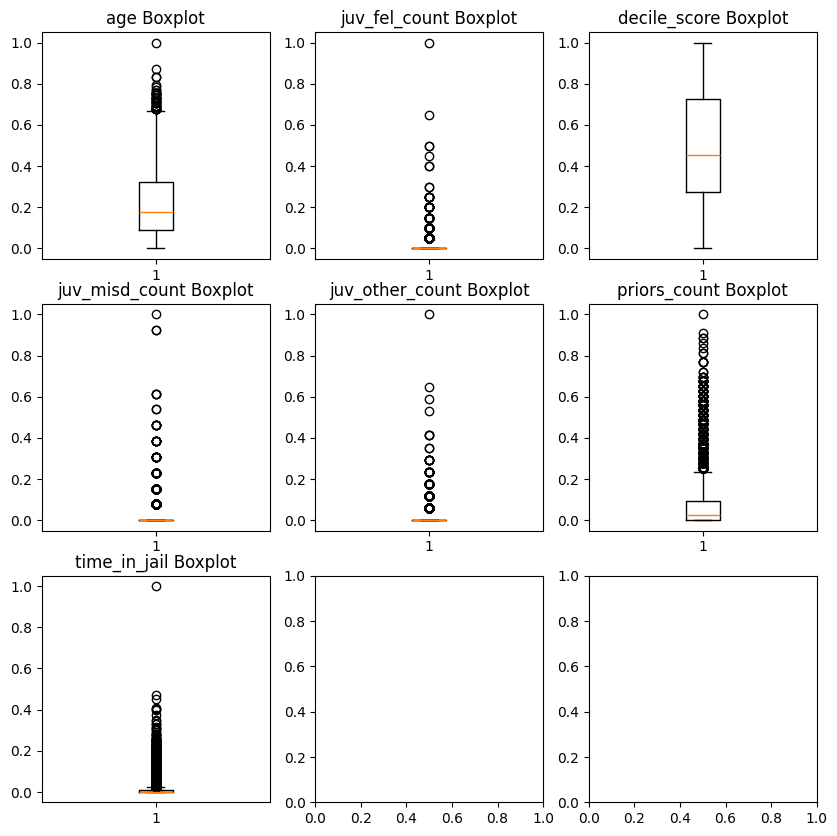

In [27]:
#Verified wether there are still outlier values by employing boxplot
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for index,attribute in enumerate(numerical_cols):
    row = index // 3
    col = index % 3
    axs[row,col].boxplot(df_tidy[attribute])
    axs[row,col].set_title(attribute + ' Boxplot')
plt.show()

In [28]:
def calculate_interquartil_interval(column_name):
    Q1 = df_tidy[column_name].quantile(0.25)
    Q3 = df_tidy[column_name].quantile(0.75)

    # Calcolo dell'intervallo interquartile (IQR)
    IQR = Q3 - Q1

    # Determinazione dei limiti inferiore e superiore per gli outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

def outliers_count_all(column_names):
    for column in column_names:
        lower_bound, upper_bound = calculate_interquartil_interval(column)
        outliers = df_tidy[(df_tidy[column] < lower_bound) | (df_tidy[column] > upper_bound)]
        print(f"numbers of outliers for {column} column: {outliers.shape[0]}")

def outliers_count(column_name):
    lower_bound, upper_bound = calculate_interquartil_interval(column_name)
    outliers = df_tidy[(df_tidy[column_name] < lower_bound) | (df_tidy[column_name] > upper_bound)]
    print(f"numbers of outliers for {column_name} column: {outliers.shape[0]}")

def delete_outlier(column_name):
    lower_bound, upper_bound = calculate_interquartil_interval(column_name)
    df_filtered = df_tidy[(df_tidy[column_name] >= lower_bound) & (df_tidy[column_name] <= upper_bound)]
    return df_filtered

In [29]:
outliers_count_all(numerical_cols)

numbers of outliers for age column: 46
numbers of outliers for juv_fel_count column: 422
numbers of outliers for decile_score column: 0
numbers of outliers for juv_misd_count column: 558
numbers of outliers for juv_other_count column: 721
numbers of outliers for priors_count column: 889
numbers of outliers for time_in_jail column: 1304


In [30]:
outliers_count_all(numerical_cols)

numbers of outliers for age column: 46
numbers of outliers for juv_fel_count column: 422
numbers of outliers for decile_score column: 0
numbers of outliers for juv_misd_count column: 558
numbers of outliers for juv_other_count column: 721
numbers of outliers for priors_count column: 889
numbers of outliers for time_in_jail column: 1304


In [31]:
df_tidy = delete_outlier('age')
df_tidy = delete_outlier('decile_score')
df_tidy = delete_outlier('priors_count')
df_tidy = delete_outlier('juv_fel_count')
df_tidy = delete_outlier('juv_misd_count')
df_tidy = delete_outlier('time_in_jail')
df_tidy = delete_outlier('juv_other_count')

In [32]:
numerical_cols = df_tidy.select_dtypes(include=['float64', 'int64']).columns
outliers_count_all(numerical_cols)

numbers of outliers for age column: 0
numbers of outliers for juv_fel_count column: 0
numbers of outliers for decile_score column: 0
numbers of outliers for juv_misd_count column: 0
numbers of outliers for juv_other_count column: 0
numbers of outliers for priors_count column: 328
numbers of outliers for is_recid column: 0
numbers of outliers for time_in_jail column: 1332


In [33]:
df_tidy['time_in_jail'] = np.sqrt(df_tidy['time_in_jail'])
df_tidy['priors_count'] = np.sqrt(df_tidy['priors_count'])

In [34]:
numerical_cols = df_tidy.select_dtypes(include=['float64', 'int64']).columns
outliers_count_all(numerical_cols)

numbers of outliers for age column: 0
numbers of outliers for juv_fel_count column: 0
numbers of outliers for decile_score column: 0
numbers of outliers for juv_misd_count column: 0
numbers of outliers for juv_other_count column: 0
numbers of outliers for priors_count column: 0
numbers of outliers for is_recid column: 0
numbers of outliers for time_in_jail column: 1076


NB: even if the notebook says that time_in_jail attribute have 1076 outlier, when we have uploaded the dataset on DSD Tool all the smells have been address.

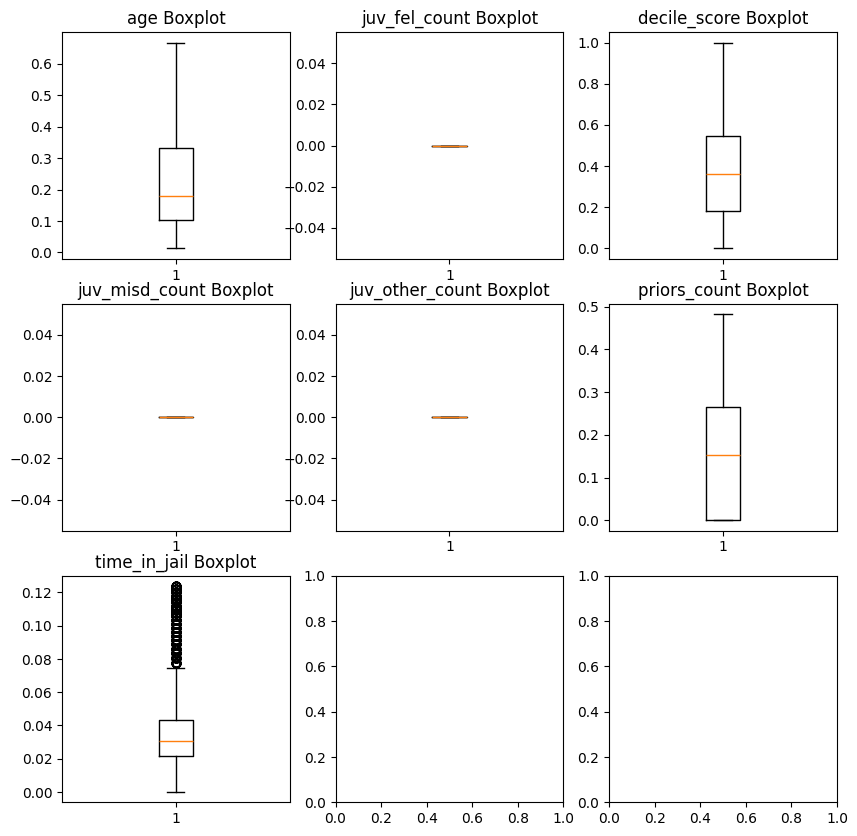

In [35]:
numerical_cols = df_tidy.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('is_recid')

#Verified wether there are still outlier values by employing boxplot
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for index,attribute in enumerate(numerical_cols):
    row = index // 3
    col = index % 3
    axs[row,col].boxplot(df_tidy[attribute])
    axs[row,col].set_title(attribute + ' Boxplot')
plt.show()

In [36]:
#As we can see from boxplots, the attributes  'juv_misd_count', 'juv_fel_count', and 'juv_other_count' only contains 0. So we can delete them.
df_tidy = df_tidy.drop(columns=['juv_misd_count', 'juv_fel_count', 'juv_other_count'])

In [37]:
categorical_columns = ["sex", "age_cat", "race", "c_charge_degree","c_charge_desc"]
df_tidy = pd.get_dummies(df_tidy, columns=categorical_columns)

In [39]:
df_tidy.to_csv('trained_tidy_compas.csv', index=False)

In [ ]:
X = df_tidy.drop(columns="is_recid")
y = df_tidy["is_recid"]

# Define four sets and apply the function
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, # 0.2 indicates a test set size of 20%
                                                    random_state=42)

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=42)

# The fit function will do the trick
dt_clf.fit(X_train, y_train)

# After the training phase, the model will be tested by predicting the values on the test set
dt_predictions = dt_clf.predict(X_test)

compute_performance_metrics(y_test,dt_predictions,"Decision Tree")

Decision Tree Accuracy: 0.6578778135048231
Decision Tree Recall: 0.3595505617977528
Decision Tree F1 Score: 0.3755868544600939


In [ ]:
svm_classifier = make_pipeline(SVC(kernel='linear'))

# Addestra il classificatore sui dati di training
svm_classifier.fit(X_train, y_train)

# Fai delle predizioni sui dati di test
svm_pred = svm_classifier.predict(X_test)

compute_performance_metrics(y_test,svm_pred,"SVM")

SVM Accuracy: 0.7106109324758842
SVM Recall: 0.04044943820224719
SVM F1 Score: 0.07407407407407407


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth = None, random_state=42)

rf_classifier.fit(X_train, y_train)

rf_predictions = rf_classifier.predict(X_test)

compute_performance_metrics(y_test,rf_predictions,"Random Forest")

Random Forest Accuracy: 0.707395498392283
Random Forest Recall: 0.2247191011235955
Random Forest F1 Score: 0.3053435114503817


In [ ]:
#CALCOLO LE METRICHE DI FAIRNESS CONSIDERANDO COME MODELLO IL DECISION TREE
dataset = X_test.copy(deep=True) # we create a copy of the test set
dataset['is_recid'] = y_test  # and join the target feature with the others
predictions = dataset.copy(deep=True) # we do the same task
predictions['is_recid'] = dt_predictions # but this time the target feature is made by the predictions of our model

race_privileged = "race_Caucasian"
race_unprivileged = ["race_African-American", "race_Asian", "race_Other", "race_Native American", "race_Hispanic"]
sex_privileged = "sex_Female"
sex_unprivileged = ["sex_Male"]

In [ ]:
fairness_metrics = compute_classification_metric(dataset,predictions,"is_recid",0,1,sex_privileged,sex_unprivileged)
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): -0.043
Average Odds Difference (AOD): -0.044
Equal Opportunity Difference (EOD): -0.015


In [ ]:
#Calcolo le metriche di fairness considerando l'attributo razza come attributo sensibile
#Più precisamente, vengono calcolate considerando come:
#Attributo privilegiato la colonna race_Native_American
#Attributo non privilegiat la colonna race_african_American
#Valore di label favorevole 0 e label non favorevole 1

fairness_metrics = compute_classification_metric(dataset,predictions,"is_recid",0,1,race_privileged,race_unprivileged)
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): -0.062
Average Odds Difference (AOD): -0.06
Equal Opportunity Difference (EOD): -0.041


In [ ]:
#CALCOLO LE METRICHE DI FAIRNESS CONSIDERANDO COME MODELLO L' SVM
dataset = X_test.copy(deep=True)
dataset['is_recid'] = y_test
predictions = dataset.copy(deep=True) 
predictions['is_recid'] = svm_pred 

In [ ]:
fairness_metrics = compute_classification_metric(dataset,predictions,"is_recid",0,1,sex_privileged,sex_unprivileged)
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): -0.007
Average Odds Difference (AOD): 0.002
Equal Opportunity Difference (EOD): -0.011


In [ ]:
fairness_metrics = compute_classification_metric(dataset,predictions,"is_recid",0,1,race_privileged,race_unprivileged)
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): -0.004
Average Odds Difference (AOD): -0.004
Equal Opportunity Difference (EOD): -0.001


In [ ]:
#CALCOLO LE METRICHE DI FAIRNESS CONSIDERANDO COME MODELLO Il Random Forest
dataset = X_test.copy(deep=True)
dataset['is_recid'] = y_test
predictions = dataset.copy(deep=True) 
predictions['is_recid'] = rf_predictions 

In [ ]:
fairness_metrics = compute_classification_metric(dataset,predictions,"is_recid",0,1,sex_privileged,sex_unprivileged)
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): -0.086
Average Odds Difference (AOD): -0.093
Equal Opportunity Difference (EOD): -0.056


In [ ]:
fairness_metrics = compute_classification_metric(dataset,predictions,"is_recid",0,1,race_privileged,race_unprivileged)
compute_fairness_metrics(fairness_metrics)

Statistical Parity Difference (SPD): -0.072
Average Odds Difference (AOD): -0.079
Equal Opportunity Difference (EOD): -0.043
